# Imports

In [3]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import json

# Dataset

In [11]:
class CSVCandleDataset(Dataset):
    def __init__(
        self,
        csv_path,
        feature_cols=None,
        target_col='close',
        seq_len=7,
        transform=None,
        return_stock_id=False,
        return_year=False
        ):
        """
        csv_path: путь к CSV-файлу
        feature_cols: фичи
        target_column: имя колонки с таргетом
        seq_len: длина временного ряда
        transform: преобразования
        return_stock_id: нужно ли возвращать тикет компании
        """
        self.df = pd.read_csv(csv_path, parse_dates=['datetime'])
        self.seq_len = seq_len
        self.target_col = target_col
        self.transform = transform
        self.return_stock_id = return_stock_id

        self.feature_cols = feature_cols or ['open', 'high', 'low', 'close', 'log_volume']

        self.X = []
        self.y = []
        self.stocks = []

        for (stock_id, date), group in self.df.groupby(['stock_id', 'date']):
            group = group.sort_values('datetime')

            x_part = group.iloc[:seq_len - 1]  # первые 6 свечей
            y_row = group.iloc[seq_len - 1]    # 7-я свеча

            x = x_part[self.feature_cols].values.astype('float32')
            y = y_row[self.target_col]

            if np.isnan(x).any() or np.isinf(x).any():
                continue

            if np.isnan(y) or np.isinf(y):
                continue

            if self.transform:
                x = self.transform(x)

            self.X.append(torch.tensor(x))  # shape: [6, num_features]
            self.y.append(torch.tensor(y, dtype=torch.float32))
            self.stocks.append(stock_id)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.return_stock_id:
            return self.X[idx], self.y[idx], self.stocks[idx]
        else:
            return self.X[idx], self.y[idx]


# Scaler

In [6]:
class StockScaler:
    def __init__(self, stats_path):
        with open(stats_path, 'r') as f:
            self.stats = json.load(f)

    def normalize(self, df, stock_id):
        df = df.copy()
        df['log_volume'] = np.log1p(df['volume'])
        for col in ['open', 'high', 'low', 'close', 'log_volume']:
            mean = self.stats[stock_id][col]['mean']
            std = self.stats[stock_id][col]['std']
            df[col] = (df[col] - mean) / std
        return df

    def denormalize_y(self, y_pred, stock_id):
        std = self.stats[stock_id]['close']['std']
        mean = self.stats[stock_id]['close']['mean']
        return y_pred * std + mean

# Model

In [7]:
class CandleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x: Tensor shape (batch_size, seq_len=6, input_dim)
        """
        x = self.input_proj(x)  # (B, 6, d_model)
        x = self.encoder(x)     # (B, 6, d_model)
        x_last = x[:, -1, :]    # (B, d_model)
        out = self.regressor(x_last)  # (B, 1)
        return out.squeeze(1)         # (B,)


# Trainer

In [8]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    model.eval() if is_test else model.train()
    total_loss = 0

    for data, target in tqdm(data_loader, desc="Test" if is_test else "Train"):
        data, target = data.to(device), target.to(device)

        if not is_test:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        if not is_test:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader,
                epochs=10, lr=1e-3, device='cpu',
                save_path='./weights/best_model.pth',
                weight_decay=1e-4):

    criterion = nn.SmoothL1Loss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        train_loss = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        val_loss = run_epoch(model, val_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Val   Loss: {val_loss:.6f}")
        print("-" * 40)

        if val_loss < best_val_loss and save_path is not None:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(model.state_dict(), save_path)
            print(f"Лучшие веса сохранены в {save_path} (Val Loss: {best_val_loss:.6f})")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses
    }


# Train

In [9]:
def plot_training_history(history):
    train_losses = history['train_losses']
    val_losses = history['val_losses']
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
train_dataset = CSVCandleDataset('/content/drive/MyDrive/archive/train_h1_scaled.csv')
val_dataset = CSVCandleDataset('/content/drive/MyDrive/archive/val_h1_scaled.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = CandleTransformer(
    input_dim=5,       # ['open', 'high', 'low', 'close', 'log_volume']
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1
).to(device)

# Запуск обучения
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=1e-3,
    device=device,
    save_path='/content/drive/MyDrive/weights/best_transformer_v2.pth',
    weight_decay=1e-4
)

Using device: cuda


Test: 100%|██████████| 258/258 [00:00<00:00, 423.20it/s]


Epoch 1/10
Train Loss: 0.003152
Val   Loss: 0.002281
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.002281)


Test: 100%|██████████| 258/258 [00:00<00:00, 421.78it/s]


Epoch 2/10
Train Loss: 0.000832
Val   Loss: 0.003201
----------------------------------------


Test: 100%|██████████| 258/258 [00:00<00:00, 419.84it/s]


Epoch 3/10
Train Loss: 0.000630
Val   Loss: 0.000752
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.000752)


Test: 100%|██████████| 258/258 [00:00<00:00, 388.89it/s]


Epoch 4/10
Train Loss: 0.000366
Val   Loss: 0.000197
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.000197)


Test: 100%|██████████| 258/258 [00:00<00:00, 297.48it/s]


Epoch 5/10
Train Loss: 0.000347
Val   Loss: 0.000232
----------------------------------------


Test: 100%|██████████| 258/258 [00:00<00:00, 307.86it/s]


Epoch 6/10
Train Loss: 0.000311
Val   Loss: 0.000344
----------------------------------------


Test: 100%|██████████| 258/258 [00:00<00:00, 321.72it/s]


Epoch 7/10
Train Loss: 0.000258
Val   Loss: 0.000177
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.000177)


Test: 100%|██████████| 258/258 [00:00<00:00, 308.75it/s]


Epoch 8/10
Train Loss: 0.000276
Val   Loss: 0.000138
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.000138)


Test: 100%|██████████| 258/258 [00:00<00:00, 324.20it/s]


Epoch 9/10
Train Loss: 0.000230
Val   Loss: 0.000139
----------------------------------------


Test: 100%|██████████| 258/258 [00:00<00:00, 363.71it/s]

Epoch 10/10
Train Loss: 0.000293
Val   Loss: 0.000137
----------------------------------------
Лучшие веса сохранены в /content/drive/MyDrive/weights/best_transformer_v2.pth (Val Loss: 0.000137)


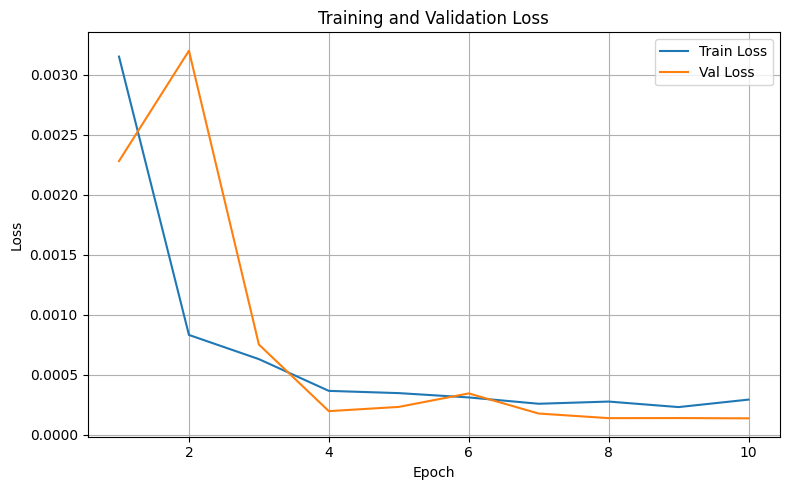

In [14]:
plot_training_history(history)

# Test

In [15]:
def inverse_transform(y_pred, stock_ids, stats_dict, target_col='close'):
    """
    Преобразует нормализованные предсказания обратно в оригинальный масштаб
    """
    y_denorm = []
    for y, stock_id in zip(y_pred, stock_ids):
        mean = stats_dict[stock_id][target_col]['mean']
        std = stats_dict[stock_id][target_col]['std']
        y_denorm.append(y * std + mean)
    return torch.tensor(y_denorm)


def inverse_transform_by_year(y_pred, stock_ids, years, stats_dict, target_col='close'):
    """
    Преобразует нормализованные предсказания обратно в оригинальный масштаб
    """
    y_denorm = []
    for y, stock_id, year in zip(y_pred, stock_ids, years):
        try:
            mean = stats_dict[stock_id][str(int(year))][target_col]['mean']
        except KeyError as e:
            print(stock_id, str(int(year)))
            exit(0)
        std = stats_dict[stock_id][str(int(year))][target_col]['std']
        y_denorm.append(y * std + mean)
    return torch.tensor(y_denorm)


@torch.no_grad()
def test_model(model, dataloader, device='cuda', scaler_json_path='/content/drive/MyDrive/archive/scaler_stats.json'):
    model.eval()

    # Загрузим статистики для обратного преобразования
    with open(scaler_json_path, 'r') as f:
        scaler_stats = json.load(f)

    total_loss = 0
    all_preds = []
    all_targets = []
    all_stock_ids = []

    criterion = torch.nn.SmoothL1Loss()

    for data, target, stock_ids in tqdm(dataloader, desc='Testing'):
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = criterion(output, target)
        total_loss += loss.item()

        all_preds.extend(output.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_stock_ids.extend(stock_ids)

    # Обратное преобразование
    y_pred_denorm = inverse_transform(all_preds, all_stock_ids, scaler_stats)
    y_true_denorm = inverse_transform(all_targets, all_stock_ids, scaler_stats)

    mae = torch.mean(torch.abs(y_pred_denorm - y_true_denorm)).item()
    mse = torch.mean((y_pred_denorm - y_true_denorm)**2).item()

    print(f"Test Loss (SmoothL1): {total_loss / len(dataloader):.6f}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")

    return {
        'loss': total_loss / len(dataloader),
        'mae': mae,
        'mse': mse,
        'y_pred': y_pred_denorm.numpy(),
        'y_true': y_true_denorm.numpy()
    }


In [16]:
test_dataset = CSVCandleDataset('/content/drive/MyDrive/archive/test_h1_scaled.csv', return_stock_id=True, return_year=True)
print(len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

33043


In [17]:
report = test_model(model, test_loader, device, scaler_json_path='/content/drive/MyDrive/archive/scaler_stats.json')
print(report['y_pred'])
print(report['y_true'])

Testing: 100%|██████████| 517/517 [00:00<00:00, 696.80it/s]

Test Loss (SmoothL1): 0.000131
MAE: 3.5467, MSE: 140.8644
[  42.01938    40.76384    39.973557 ... 4104.281    4139.7173
 4112.214   ]
[  41.9   40.7   39.9 ... 4104.2 4133.6 4115.6]


v1
Test Loss (SmoothL1): 0.000194

MAE: 4.5843, MSE: 200.3891

[  42.00152,    40.74257,    40.030727, ..., 4106.398,    4143.4043, 4115.68   ]

[  41.9,   40.7,   39.9, ..., 4104.2, 4133.6, 4115.6]